In [1]:
import os
import os.path as osp
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import torchvision.transforms as transforms

from models import model_dict
from zoo import Attention, Similarity
from dataset import CIFAR100
from utils import accuracy, val, AverageMeter, cal_center

In [2]:
# Specify that you want to use GPU 6
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

# Loading the dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761]),
])

In [4]:
trainset = CIFAR100('./data', train=True, transform=transform)
valset = CIFAR100('./data', train=False, transform=transform)
num_classes = 100

train_loader = DataLoader(trainset, batch_size=64, \
            shuffle=False, num_workers=3, pin_memory=True)
val_loader = DataLoader(valset, batch_size=64, \
            shuffle=False, num_workers=3, pin_memory=True)

# Loading the teacher and the student

In [21]:
chkpt = 'experiments/teacher_resnet56/ckpt/best.pth'
state_dict = torch.load(chkpt, map_location='cuda')['state_dict']
teacher = model_dict['resnet56'](num_classes=100)
teacher.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
chkpt = 'experiments/teacher_resnet20/ckpt/best.pth'
state_dict = torch.load(chkpt, map_location='cuda')['state_dict']
model = model_dict['resnet20'](num_classes=100)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
model = model.cuda()
teacher = teacher.cuda()

# Getting teacher and student accuracy

In [24]:
# get test accuracy
correct = 0
total = 0
teacher.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = teacher(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Teacher model accuracy: {:.2f}%'.format(acc))

Teacher model accuracy: 73.43%


In [25]:
# get test accuracy
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Student model accuracy: {:.2f}%'.format(acc))

Student model accuracy: 69.61%


# Student Uncertainty versus teacher uncertainty

In [48]:
s_indices = []
s_entropy = []
s_margin = []
model.eval()
with torch.no_grad():
    for inputs, targets, indx in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)
        entropy = -torch.sum(prob * torch.log(prob), dim=1)
        rank = torch.argsort(prob, dim=1)
        top2 = torch.gather(prob, dim=1, index = rank[:,-2:])
        margin = top2[:,-1] - top2[:,-2]
        s_indices.append(indx)
        s_entropy.append(entropy)
        s_margin.append(margin)

In [49]:
t_indices = []
t_entropy = []
t_margin = []
t_prob_correct = []
teacher.eval()
with torch.no_grad():
    for inputs, targets, indx in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = teacher(inputs)
        prob = F.softmax(outputs, dim=1)
        entropy = -torch.sum(prob * torch.log(prob), dim=1)
        rank = torch.argsort(prob, dim=1)
        top2 = torch.gather(prob, dim=1, index = rank[:,-2:])
        margin = top2[:,-1] - top2[:,-2]
        #prob that teacher is correct
        prob_correct = prob[torch.arange(prob.size(0)), targets]
        t_prob_correct.append(prob_correct)
        t_indices.append(indx)
        t_entropy.append(entropy)
        t_margin.append(margin)

In [50]:
s_indices = torch.cat(s_indices).cpu().numpy()
s_entropy = torch.cat(s_entropy).cpu().numpy()
s_margin = torch.cat(s_margin).cpu().numpy()
t_indices = torch.cat(t_indices).cpu().numpy()
t_entropy = torch.cat(t_entropy).cpu().numpy()
t_margin = torch.cat(t_margin).cpu().numpy()
t_prob_correct = torch.cat(t_prob_correct).cpu().numpy()

Text(0, 0.5, 'Student entropy')

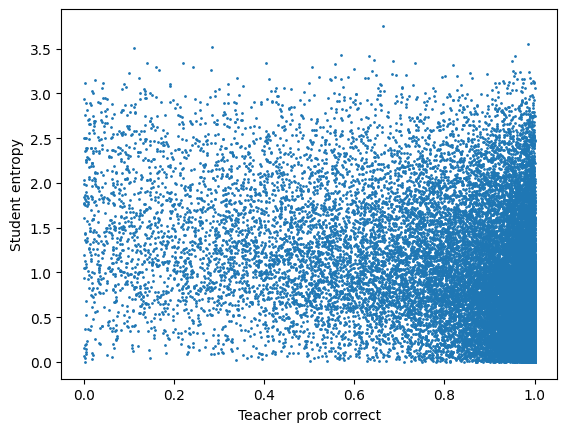

In [51]:
#plot teacher prob correct vs student entropy
import matplotlib.pyplot as plt
plt.scatter(t_prob_correct, s_entropy, s=1)
plt.xlabel('Teacher prob correct')
plt.ylabel('Student entropy')

Text(0, 0.5, 'Student entropy')

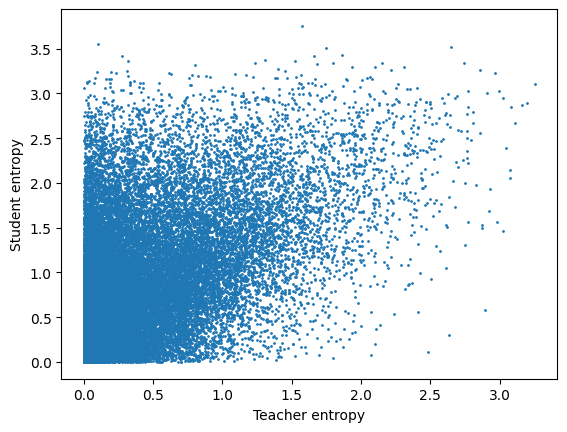

In [36]:
# plot the student uncertainty vs teacher uncertainty
#sort the stduent uncertainty based on increasing teacher uncertainty
idx = np.argsort(t_entropy)
t_entropy_sort = t_entropy[idx]
s_entropy_sort = s_entropy[idx]
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(t_entropy_sort, s_entropy_sort, s=1)
plt.xlabel('Teacher entropy')
plt.ylabel('Student entropy')

In [37]:
lamb = np.random.beta(1, 1)

In [40]:
# now generate random mixup images and compute the uncertainty
s_mix_indices = []
s_mix_entropy = []
s_mix_margin = []
model.eval()
with torch.no_grad():
    for inputs, targets, indx in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs = inputs * lamb + (1-lamb)*inputs[torch.randperm(inputs.size(0))]
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)
        entropy = -torch.sum(prob * torch.log(prob), dim=1)
        rank = torch.argsort(prob, dim=1)
        top2 = torch.gather(prob, dim=1, index = rank[:,-2:])
        margin = top2[:,-1] - top2[:,-2]
        s_mix_indices.append(indx)
        s_mix_entropy.append(entropy)
        s_mix_margin.append(margin)

In [41]:
t_mix_indices = []
t_mix_entropy = []
t_mix_margin = []
teacher.eval()
with torch.no_grad():
    for inputs, targets, indx in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs = inputs * lamb + (1-lamb)*inputs[torch.randperm(inputs.size(0))]
        outputs = teacher(inputs)
        prob = F.softmax(outputs, dim=1)
        entropy = -torch.sum(prob * torch.log(prob), dim=1)
        rank = torch.argsort(prob, dim=1)
        top2 = torch.gather(prob, dim=1, index = rank[:,-2:])
        margin = top2[:,-1] - top2[:,-2]
        t_mix_indices.append(indx)
        t_mix_entropy.append(entropy)
        t_mix_margin.append(margin)

In [43]:
s_mix_indices = torch.cat(s_mix_indices).cpu().numpy()
s_mix_entropy = torch.cat(s_mix_entropy).cpu().numpy()
s_mix_margin = torch.cat(s_mix_margin).cpu().numpy()
t_mix_indices = torch.cat(t_mix_indices).cpu().numpy()
t_mix_entropy = torch.cat(t_mix_entropy).cpu().numpy()
t_mix_margin = torch.cat(t_mix_margin).cpu().numpy()

Text(0, 0.5, 'Student entropy')

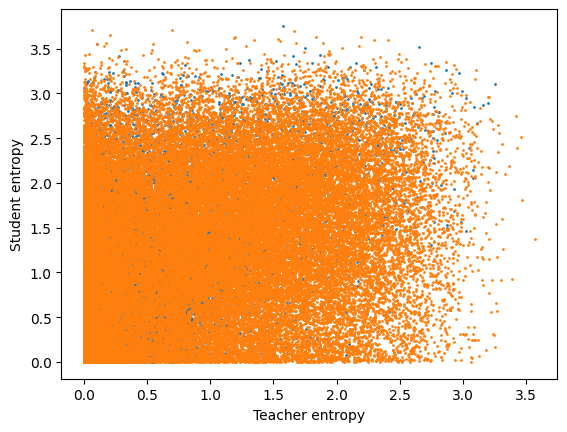

In [44]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(t_entropy_sort, s_entropy_sort, s=1, label ='true')
plt.scatter(t_mix_entropy, s_mix_entropy, s=1, label='mixup')
plt.xlabel('Teacher entropy')
plt.ylabel('Student entropy')

In [110]:
index_list = []
entropy = []
margin = []
model.eval()
with torch.no_grad():
    for inputs, targets, index in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)
        log_prob = F.log_softmax(outputs, dim=1)
        entropy.append(-1 * (prob * log_prob).sum(dim=1))
        margin.append(prob.max(dim=1)[0] - prob[torch.arange(len(targets)), targets])
        index_list.append(index)

In [111]:
# sort the entropy and the index according to the entropy
entropy = torch.cat(entropy)
margin = torch.cat(margin)
index_list = torch.cat(index_list)
sorted_entropy, entropy_index = entropy.sort(descending=True)
sorted_margin, margin_index = margin.sort(descending=True)



Text(0.5, 1.0, 'Entropy of training data')

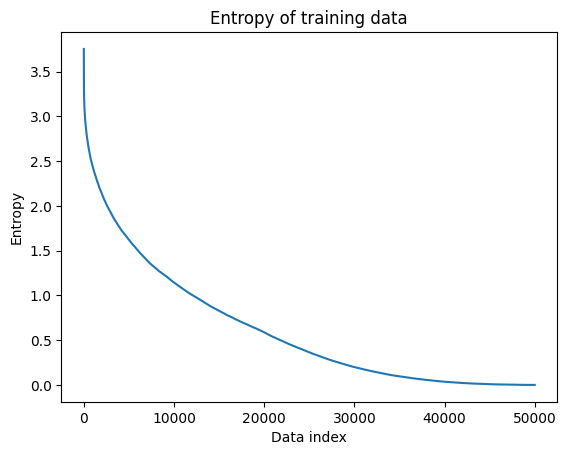

In [112]:
# plot entropy versus 1 to50000
import matplotlib.pyplot as plt
plt.plot(sorted_entropy.cpu().numpy())
plt.xlabel('Data index')
plt.ylabel('Entropy')
plt.title('Entropy of training data')


In [179]:
mode = 'ud' #ud: up down bu: both up and bd: both down
if mode=='ud':
    threshold_up = 3
    # index_conf = torch.where(sorted_entropy > threshold, entropy_index)[0]
    index_conf_up = torch.where(entropy > threshold_up)[0]

    threshold_down = 1
    index_conf_down = torch.where(entropy < threshold_down)[0]
    # select two random points-one from each group
    choice_up = np.random.choice(index_conf_up.cpu().numpy(), 1)
    choice_down = np.random.choice(index_conf_down.cpu().numpy(), 1)
    choice = np.concatenate((choice_up, choice_down))
elif mode=='bu':
    threshold_up = 3
    # index_conf = torch.where(sorted_entropy > threshold, entropy_index)[0]
    index_conf_up = torch.where(entropy > threshold_up)[0]
    choice = np.random.choice(index_conf_up.cpu().numpy(), 2)
elif mode=='bd':
    threshold_down = 2
    index_conf_down = torch.where(entropy < threshold_down)[0]
    choice = np.random.choice(index_conf_down.cpu().numpy(), 2)


In [180]:
choice = sorted(choice, key=lambda x: entropy[x])

print(entropy[choice[0]])
print(entropy[choice[1]])

tensor(0.2458, device='cuda:0')
tensor(3.1100, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


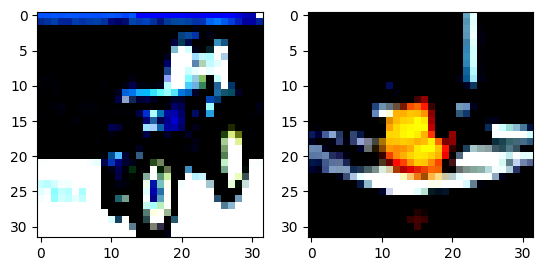

In [181]:
# get the img of the two points
import torchvision
import matplotlib.pyplot as plt
img1 = trainset[choice[0]][0].permute(1, 2, 0)
img2 = trainset[choice[1]][0].permute(1, 2, 0)
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()


In [182]:
# now vary the mixup constant between the two images and compute the entropy of the mixupped image
img1 = trainset[choice[0]][0].cuda()
img2 = trainset[choice[1]][0].cuda()
#print entropy of the two images
output1 = model(img1.unsqueeze(0))
output2 = model(img2.unsqueeze(0))
prob1 = F.softmax(output1, dim=1)
log_prob1 = F.log_softmax(output1, dim=1)
entropy1 = -1 * (prob1 * log_prob1).sum(dim=1)
prob2 = F.softmax(output2, dim=1)
log_prob2 = F.log_softmax(output2, dim=1)
entropy2 = -1 * (prob2 * log_prob2).sum(dim=1)
print(f"entropy1 = {entropy1.item()}")
print(f"entropy2 = {entropy2.item()}")
entropy_mixup_list = []
for alpha in np.arange(0, 1.0001, 0.05):
    img_mixup = alpha * img1 + (1-alpha) * img2
    img_mixup = img_mixup.unsqueeze(0)
    output_mixup = model(img_mixup)
    prob_mixup = F.softmax(output_mixup, dim=1)
    log_prob_mixup = F.log_softmax(output_mixup, dim=1)
    entropy_mixup = -1 * (prob_mixup * log_prob_mixup).sum(dim=1)
    if alpha==0 or alpha==1:
        print(f"alpha={alpha}: entrop = {entropy_mixup.item()}")
    entropy_mixup_list.append(entropy_mixup.item())

entropy1 = 0.24541759490966797
entropy2 = 3.1097240447998047
alpha=0.0: entrop = 3.1097240447998047
alpha=1.0: entrop = 0.24541759490966797


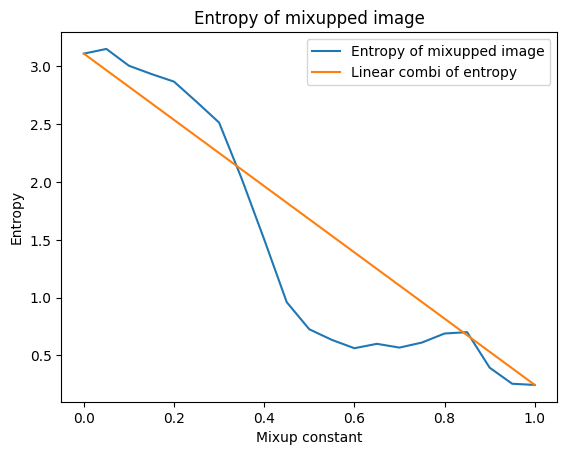

In [183]:
plt.plot(np.arange(0, 1.0001, 0.05), entropy_mixup_list, label='Entropy of mixupped image')
plt.plot(np.arange(0, 1.0001, 0.05), np.arange(0, 1.0001, 0.05) * entropy[choice[0]].item() + (1-np.arange(0, 1.0001, 0.05)) * entropy[choice[1]].item(), label='Linear combi of entropy')
plt.xlabel('Mixup constant')
plt.ylabel('Entropy')
plt.title('Entropy of mixupped image')
plt.legend()